# Joe Stanley
### Stanley Solutions
Testing and modeling environment for water heating/cooling model.

References:
- http://jwilson.coe.uga.edu/EMAT6680Fa07/Lowe/Assignment%2012/CoolingWater.html
- https://sciencing.com/calculate-time-heat-water-8028611.html

In [1]:
# Import Libraries
import numpy as np
import math as m
import matplotlib.pyplot as plt
from scipy.constants import convert_temperature as conv_temp
from scipy.optimize import curve_fit
from collections import OrderedDict

# Define System Parameters
k = 0.01457 # From Web, not Terribly Accurate
g = 10 # Gallons in Container
P = 500

###### ALL TIME IS MEASURED IN MINUTES #####

In [2]:
# Define Modeling Functions
def gallons(liters):
    gal = liters/3.78541
    return(gal)
def liters(gallons):
    lit = gallons*3.78541
    return(lit)

def newtoncooling(t,temp0,tempenv):
    temp = tempenv + (temp0-tempenv)*np.exp(-k*t)
    return(temp)

def heating(t,Power,temp0):
    temp0 = conv_temp(temp0,'f','c')
    Pkw = Power/1000
    temp = temp0 + (60*Pkw*t)/(4.2*liters(g))
    print(temp0,Pkw,liters(g))
    temp = conv_temp(temp,'c','f')
    return(temp)

def combined(t,Power,temp0,tempenv):
    cool = newtoncooling(t,temp0,tempenv)
    heat = heating(t,Power,temp0) - temp0
    return(cool+heat)

1.6666666666666856 0.5 37.8541
1.6666666666666856 0.5 37.8541


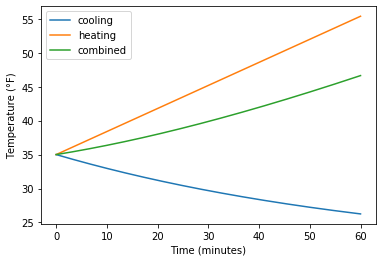

In [3]:
# Model SIMPLE Systems, Nothing Advanced
t_hr = np.linspace(0,60,600)
t0 = 35
te = 20
cool = newtoncooling(t_hr,t0,te)
heat = heating(t_hr,P,t0)
sys = combined(t_hr,P,t0,te)
plt.plot(t_hr, cool, label='cooling')
plt.plot(t_hr, heat, label='heating')
plt.plot(t_hr, sys, label='combined')
plt.xlabel("Time (minutes)")
plt.ylabel("Temperature (°F)")
plt.legend()
plt.show()

## First model was not accurate...
It did not appropriately account for time.

In [4]:
# Define Avista Billing Rates
ratelt600 = 0.08458 # $/kwh
rategt600 = 0.09521 # $/kwh

In [5]:
# Define New Temperature Model
class troughmodel():
    def __init__(self,temp0,Pwatts,volume,k,threshold=45,freezing_threshold=33):
        # Define Simple Heater
        self._t0 = temp0
        self._Pkw = Pwatts/1000
        self._k = k
        self._temp = [temp0]
        self._heater_en = [False]
        self._threshold = threshold
        self._volume = volume
        self._index = 0
        self._tactv = freezing_threshold # Frezing, Activate Point
    
    def update(self,ambient,EN=True,k=None):
        # Temperature over Time Method, Models Heater and Cooling Params
        if k != None:
            self._k = k
        temp = self._temp[self._index]
        # Determine Temperature Change from Both Heating and Cooling
        newTemp = ambient + (temp-ambient)*np.exp(-self._k)
        heatC = (temp-32)*5/9 + (60*self._Pkw)/(4.2*liters(self._volume))
        heat = (heatC*9/5) + 32
        # Convert Heating Effect back to Fahrenheit
        dt_heat = heat-temp
        # Determine whether Heater should be Applied
        if temp >= self._threshold:
            self._heater_en.append(False) # Don't Heat
        elif EN and ((temp <= self._tactv) or self._heater_en[self._index-1]):
            self._heater_en.append(True) # Apply Heater
            newTemp += dt_heat
        else:
            self._heater_en.append(False) # Don't Heat
        # Increment Index and Return New Temperature
        self._index += 1
        self._temp.append(newTemp)
        return(newTemp)
    
    def min_maintain(self,temp_maint=None):
        # Minimum Maintainable Temperature Method; Determines Minimum Ambient
        # Temperature to Maintain (at least) the Maintenence Temperature
        temp = self._tactv # Freezing Point
        if temp_maint != None:
            temp = temp_maint
        # Iteratively Process Temperatures between -10 and 32
        for ambient in range(-10,32):
            # Determine Temperature Change from Both Heating and Cooling
            dcool = temp - (ambient + (temp-ambient)*np.exp(-self._k))
            heatC = (temp-32)*5/9 + (60*self._Pkw)/(4.2*liters(self._volume))
            heat = (heatC*9/5) + 32
            dheat = heat-temp
            if dheat >= dcool:
                mintemp = ambient
                return(mintemp)
    
    def time_to_recover(self,ambient,temp_recovr=None,t0=None):
        # Time to Recover Method; Determines the Time (in minutes) required
        # to Heat the Modeled Trough from Ambient to the Recovery Threshold
        time = 0
        if t0 == None:
            temp = ambient
        else:
            temp = t0
        if temp_recovr == None:
            temp_recovr = self._tactv
        # Iteratively Process the Heating/Cooling Performance to Determine
        # the Time Required; Return -1 if more than 24 Hours Required
        while temp < temp_recovr:
            heatC = (temp-32)*5/9 + (60*self._Pkw)/(4.2*liters(self._volume))
            heat = (heatC*9/5) + 32
            dt_heat = heat-temp
            temp = ambient + (temp-ambient)*np.exp(-self._k) + dt_heat
            time += 1
            if time > 1440:
                return(-1) # Return in Error
        return(time)
    
    def rest_time(self,ambient,temp_restart=32,t0=None):
        # Determine the Allowable Resting Time Before a Heater Restart is Required
        time = 0
        if t0 == None:
            temp = self._temp[self._index]
        else:
            temp = t0
        heaterstate = self._heater_en[-1]
        if not heaterstate:
            # Iteratively Calculate New Temperature and Count Time (in minutes)
            # If Time is Greater than 24 Hours, Return -1
            while temp > temp_restart:
                # Determine Temperature Change from Both Heating and Cooling
                newTemp = ambient + (temp-ambient)*np.exp(-self._k)
                temp = newTemp
                time += 1
                if time > 1440:
                    return(-1) # Indicate Greater than 24 Hours Cool
        else:
            return(-2) # Indicate Active Heater
        return(time)
    
    def get_temp(self):
        return(self._temp)
    
    def get_heater_state(self):
        return(self._heater_en)
    
    def shrink_lists(self):
        self._temp = self._temp[-2:]
        self._heater_en = self._heater_en[-2:]

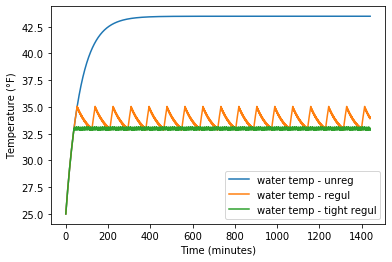

kWh Consumed (unregulated): 12.0
kWh Consumed (regulated): 7.225
kWh Consumed (tightly regulated) 6.775
Improvement: 39.79166666666667 %
Tight Improvement: 43.541666666666664 %
Minimum Ambient Temperature: 10 °F
Time To Recover from 15°F: 100 minutes


In [6]:
# Demonstrate Model in Simple System
t0 = 25
t_amb = 20

model = troughmodel(t0,P,g,k,threshold=45)
mod_1 = troughmodel(t0,P,g,k,threshold=35)
mod_2 = troughmodel(t0,P,g,k,threshold=33)

# Process twenty-four hours
minutes = 60*24
for _ in range(minutes):
    # Update the Model Instances
    model.update(t_amb)
    mod_1.update(t_amb)
    mod_2.update(t_amb)
    # Evaluate the Rest Time
    mod_1_rest = mod_1.rest_time(t_amb)
    mod_2_rest = mod_2.rest_time(t_amb)
    #if (mod_1_rest > 0) and (mod_2_rest > 0):
    #    print("Model 1:",mod_1_rest,"\t\tModel 2:",mod_2_rest)

# Display Results
plt.plot(model.get_temp(),label='water temp - unreg')
plt.plot(mod_1.get_temp(),label='water temp - regul')
plt.plot(mod_2.get_temp(),label='water temp - tight regul')
#plt.plot(model.get_heater_state(),label='heater state')
plt.xlabel("Time (minutes)")
plt.ylabel("Temperature (°F)")
plt.legend()
plt.show()

rate = sum(model.get_heater_state())/60
rate1 = sum(mod_1.get_heater_state())/60
rate2 = sum(mod_2.get_heater_state())/60
consump = (P/1000) * rate
consump1 = (P/1000) * rate1
consump2 = (P/1000) * rate2
print("kWh Consumed (unregulated):",consump)
print("kWh Consumed (regulated):",consump1)
print("kWh Consumed (tightly regulated)",consump2)
print("Improvement:",(consump-consump1)/consump*100,"%")
print("Tight Improvement:",(consump-consump2)/consump*100,"%")
print("Minimum Ambient Temperature:",model.min_maintain(),"°F")
print("Time To Recover from 15°F:",model.time_to_recover(15),"minutes")

## Start Modeling the Dispatching Sequence

Great! Now we've seen that immense amounts of efficiency can be gained by using a model to more accurately control the water heaters. We've also developed some nice methods of determining the time.

Now we need to develop appropriate methods to dispatch the heaters.

First, we need to find a way of determining how many separate heater groups can be controlled in a period of time. Ultimately, this is determined by the relationship between the amount of time that it takes for a heater to return from freezing to the threshold, and the amount of time required to cool from the threshold to freezing.

If the time required to heat is greater than the time required to cool, there are no effective ways of scheduling heat cycles. When this is true, all heaters must be enabled and controlled by their respective models, heating and cooling as appropriate.

On the contrary, when the time to heat is less than the time to cool, some number of scheduling operations may be completed. This means that some number of heaters can be enabled while others are disabled. As the temperature rises, the number of scheduling periods may also rise. When the number of scheduling periods is zero, all heaters are controlled by their models. When the number of scheduling periods is one, two groups of heaters will be maintained. When the number is two, three groups of heaters will be maintained.

Recovery Time: 12 minutes
Rest Time: 39 minutes
3.0


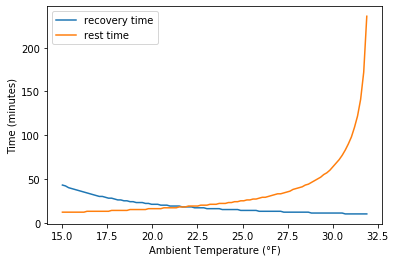

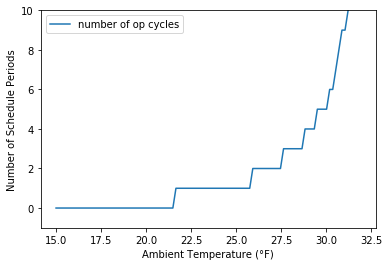

In [7]:
# Model Some Simple Dispatching Considerations
t0 = 32
t_amb = 28
threshold = 35

dispatchmodel = troughmodel(t0,P,g,k,threshold=threshold)

# Evaluate Sample Time to Recover
recoverytime = dispatchmodel.time_to_recover(t_amb,temp_recovr=threshold,t0=t0)
resttime = dispatchmodel.rest_time(t_amb,temp_restart=32,t0=threshold)

print("Recovery Time:",recoverytime,"minutes")
print("Rest Time:",resttime,"minutes")
print(np.floor(resttime/recoverytime))

# Now, let's sweep the ambient temperature to review the performance
ambient = np.linspace(15,31.9,100)

recovery = []
rest = []
n_set = []
for amb in ambient:
    # Evaluate Components
    recoverytime = dispatchmodel.time_to_recover(amb,temp_recovr=threshold,t0=t0)
    resttime = dispatchmodel.rest_time(amb,temp_restart=32,t0=threshold)
    # Store Data Points in Lists
    recovery.append( recoverytime )
    rest.append( resttime )
    # Evaluate the Number of Device Cycles per Rest Cycle
    cyc = np.floor(resttime/recoverytime)
    if cyc >= 0:
        n_set.append(cyc)
    else:
        n_set.append(0)

plt.plot(ambient,recovery,label='recovery time')
plt.plot(ambient,rest,label='rest time')
plt.legend()
plt.xlabel('Ambient Temperature (°F)')
plt.ylabel('Time (minutes)')
plt.show()

plt.plot(ambient,n_set,label='number of op cycles')
plt.xlabel('Ambient Temperature (°F)')
plt.ylabel('Number of Schedule Periods')
plt.legend()
plt.ylim(-1,10)
plt.show()

## Evaluate Accurate Temperature Constant

This temperature constant will only be valid for the 15 gallon troughs used for the individual stalls; still that's ok for our purposes.

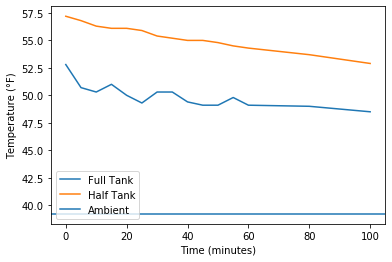

In [8]:
# Import Data from CSV
temp_data = np.genfromtxt('TemperatureRecord.csv', delimiter=',')

# Extract Useful Datapoints
temp_offset = temp_data[0][-1]
temp_ambient = temp_data[1][-1]
t_stamp = temp_data[1:, 0]
temp_full_tank = temp_data[1:, 1]
temp_half_tank = temp_data[1:, 2]

# Plot Simple Datasets
plt.plot(t_stamp,temp_full_tank-temp_offset,label='Full Tank')
plt.plot(t_stamp,temp_half_tank-temp_offset,label='Half Tank')
plt.axhline(temp_ambient,label='Ambient')
plt.xlabel('Time (minutes)')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.show()

In [9]:
# Define Curve Fit Function (Cooling Water Function)
def water_cooling(time,k,t_amb,t0):
    Tt = t_amb + (t0-t_amb)*np.exp(-k*time)
    return(Tt)

# Define Specific Curve Fit Test Cases
def full_tank(time, k):
    return(water_cooling(time,k,temp_ambient,temp_full_tank[0]))
def half_tank(time, k):
    return(water_cooling(time,k,temp_ambient,temp_half_tank[0]))

# Perform Curve Fitting Operations
k_full, cv_full = curve_fit(full_tank,t_stamp,temp_full_tank)
k_half, cv_half = curve_fit(half_tank,t_stamp,temp_half_tank)
# Format Returned Values
k_full = k_full[0]
k_half = k_half[0]
cv_full = cv_full[0][0]
cv_half = cv_half[0][0]
# Display Results
print("           \t FULL\t\t\t\t HALF\t\t\t\t ORIGINAL")
print("K Factors:\t",round(k_full,5),'\t\t\t',round(k_half,5),'\t\t\t',k)
print("Covariance:\t",cv_full,'\t',cv_half)

           	 FULL				 HALF				 ORIGINAL
K Factors:	 0.00513 			 0.00276 			 0.01457
Covariance:	 3.4689517186478773e-07 	 5.567064427190419e-09


c:\users\joestan\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


It's worth noting here that it's interesting that we see a smaller K-factor for the Half-Tank. This seems counter-intuitive. In fact, given the poor quality of the dataset, and the difference in Covariance as determined by the curve fitting model; it might be indicative of an entirely unreliable dataset for the Full-Tank. Still, the data for the Half-Tank seems reliable. Perhaps reliable enough to base our calculations upon.

Additionally, it's interesting to note that the calculated K-factors (both) are significantly smaller than the original factor (shown on right). This even further supports the early ideology that this control method could ultimately save significant ammounts of energy.

## Re-Develop Temperature Model
*We'll need to do this not only to improve the accuracy based on the new temperature constant, but also to support real-time operational control.*

We need to add some particular features like:

- Upgraded Temperature Constant (Improve Efficiency)
- Add External Influence Control (Force Heater On/Off)
- Remove Internal Recursive Solution Functions

In [15]:
# Define "Global" Parameter Settings
water_k_full = k_full
water_k_half = k_half
shutoff = 35
turn_on = 33

# Define New Single Trough (Unit) Temperature Model
class unit_model():
    def __init__(self,temp0,Pwatts,volume,k=water_k_full,
                 shutoff=shutoff,turn_on=turn_on,in_service=True):
        """
        unit_model
        
        Parameters
        ----------
        temp0:      float
                    Initial Temperature (degrees F)
        Pwatts:     float
                    Heater Element Rated Power in Watts
        volume:     float
                    Trough/Container Volume in Gallons
        k:          float, optional
                    Water Temperature Constant for Container,
                    defaults to 15-gallon full constant
        shutoff:    float, optional
                    Threshold to turn off heater (upper limit)
        turn_on:    float, optional
                    Threshold to turn on heater (lower limit)
        in_service: bool, optional
                    Control argument to enable or disable system.
        """
        # Define Simple Heater Internal Parameters
        # All Internal Parameters are Private, and Should be Hidden
        self._t0 = temp0
        self._Pkw = Pwatts*0.001
        self._k = k
        self._temp = temp0
        self._heater_en = False
        self._threshold = shutoff
        self._volume = volume
        self._force_on = 0
        self._force_off = 0
        self._in_service = in_service
        self._tactv = turn_on # Frezing, Activate Point
        # This Freezing (Activate Point) Specifys the Water Temperature
        # at which the model evaluates a required turn-on.
    
    def get_service(self):
        # Return Internal Service State
        return(self._in_service)
    
    def get_heater_state(self):
        # Return Internal Heater State
        return(self._heater_en)
    
    def get_temp(self):
        # Return Internal Temperature
        return(self._temp)
    
    def get_power(self):
        # Return Internal Heater Power Rating
        return(self._Pkw)
    
    def force(self,force_on=None,force_off=None):
        """
        unit_model.force
        
        Parameters
        ----------
        force_on:   int, optional
                    Control to force the heater on for a number of minutes.
        force_off:  int, optional
                    Control to force the heater off for a number of minutes.
        """
        # Accept Any External Configuration Controls
        if force_on != None:
            self._force_on = force_on
            self._force_off = 0
        elif force_off != None:
            self._force_off = force_off
            self._force_on = 0
    
    def update(self,ambient,EN=True):
        """
        unit_model.update
        
        Parameters
        ----------
        ambient:    float
                    Current ambient temperature.
        """
        # Temperature over Time Method, Models Heater and Cooling Params
        # Capture Most Recent Water Temperature
        temp = self._temp
        # Determine Temperature Change from Both Heating and Cooling
        newTemp = ambient + (temp-ambient)*m.exp(-self._k)
        heatC = (temp-32)*5/9 + (60*self._Pkw)/(4.2*liters(self._volume))
        heat = (heatC*9/5) + 32
        # Convert Heating Effect back to Fahrenheit
        dt_heat = heat-temp
        # Determine whether Heater should be Applied
        # (Temperature is Above Upper Limit and not Forced On) or Forced Off
        if ((temp >= self._threshold) and (self._force_on == 0)) or self._force_off:
            self._heater_en = False # Don't Heat
        # If System In Service and (Temp Below Threshold or Heater Already On) or Forced On
        elif (self._in_service and EN and ((temp <= self._tactv) or self._heater_en)) or self._force_on:
            self._heater_en = True # Apply Heater
            newTemp += dt_heat
        # Don't Heat By Default
        else:
            self._heater_en = False # Don't Heat
        # Decrement Force States if Any are Present
        if self._force_on:
            self._force_on -= 1
        if self._force_on:
            self._force_off -= 1
        # Store Temperature, Return Heater Status
        self._temp = newTemp
        return(self._heater_en)
    
    def cycle_baseline(self,lut_fmt=True,mintemp=22,maxtemp=31.9,units=12):
        # Method to Calculate the Baseline Number of Operating Cycles Allowed
        step_size = 0.1
        baseline = [] # Empty List to Begin
        basetemp = [] # Empty List to Begin
        # Load Internal Values
        Pkw = self._Pkw
        volume = self._volume
        temp_recovr = self._threshold
        temp_restart = self._tactv
        k = self._k
        ambient = mintemp
        # Iteratively Calculate Baseline Number of Cycles
        while ambient <= maxtemp:
            recovery = 0
            rest = 0
            temp_rest = temp_recovr
            temp_recv = ambient
            state = 2
            # Iteratively Process the Heating/Cooling Performance
            while state != 0:
                if temp_recv < temp_recovr:
                    heatC = (temp_recv-32)*5/9 + (60*Pkw)/(4.2*liters(volume))
                    heat = (heatC*9/5) + 32
                    dt_heat = heat-temp_recv
                    temp_recv = ambient + (temp_recv-ambient)*m.exp(-k) + dt_heat
                    recovery += 1
                    if not (temp_recv < temp_recovr):
                        state -= 1 # Indicate Completion of Test
                if temp_rest > temp_restart:
                    # Determine Temperature Change from Cooling
                    newTemp = ambient + (temp_rest-ambient)*m.exp(-k)
                    temp_rest = newTemp
                    rest += 1
                    if not (temp_rest > temp_restart):
                        state -= 1 # Indicate Completion of Test
            # Times have been Calculated, Store Baseline
            floor = m.floor(rest/recovery)
            if floor < 0:
                floor = 0
            elif floor > units:
                floor = units
            baseline.append(floor)
            basetemp.append(ambient)
            # Increment Ambient Temperature (Acting Index)
            ambient += step_size
        # Baseline has been fully Generated
        if lut_fmt:
            return(dict(zip([ '%.1f' % elem for elem in basetemp ],baseline)))
        return(basetemp,baseline)
    
    def baseline_const(self):
        baseline = self.cycle_baseline()
        for key,value in baseline.items():
            if value == 1:
                return(key)
    
def min_maintain(volume,Pwatts,temp_maint=None,k=water_k_full):
    # Minimum Maintainable Temperature Method; Determines Minimum Ambient
    # Temperature to Maintain (at least) the Maintenence Temperature
    temp = turn_on # Freezing Point
    Pkw = Pwatts*0.001
    if temp_maint != None:
        temp = temp_maint
    # Iteratively Process Temperatures between -10 and 32
    for ambient in range(-10,32):
        # Determine Temperature Change from Both Heating and Cooling
        dcool = temp - (ambient + (temp-ambient)*m.exp(-k))
        heatC = (temp-32)*5/9 + (60*Pkw)/(4.2*liters(volume))
        heat = (heatC*9/5) + 32
        dheat = heat-temp
        if dheat >= dcool:
            mintemp = ambient
            return(mintemp)

def time_to_recover(ambient,volume,Pwatts,temp_recovr=None,t0=None,k=water_k_full):
    # Time to Recover Method; Determines the Time (in minutes) required
    # to Heat the Modeled Trough from Ambient to the Recovery Threshold
    time = 0
    Pkw = Pwatts*0.001
    if t0 == None:
        temp = ambient
    else:
        temp = t0
    if temp_recovr == None:
        temp_recovr = turn_on
    # Iteratively Process the Heating/Cooling Performance to Determine
    # the Time Required; Return -1 if more than 24 Hours Required
    while temp < temp_recovr:
        heatC = (temp-32)*5/9 + (60*Pkw)/(4.2*liters(volume))
        heat = (heatC*9/5) + 32
        dt_heat = heat-temp
        temp = ambient + (temp-ambient)*m.exp(-k) + dt_heat
        time += 1
        if time > 1440:
            return(-1) # Return in Error
    return(time)

def rest_time(ambient,t0,temp_restart=turn_on,k=water_k_full):
    # Determine the Allowable Resting Time Before a Heater Restart is Required
    time = 0
    temp = t0
    # Iteratively Calculate New Temperature and Count Time (in minutes)
    # If Time is Greater than 24 Hours, Return -1
    while temp > temp_restart:
        # Determine Temperature Change from Both Heating and Cooling
        newTemp = ambient + (temp-ambient)*m.exp(-k)
        temp = newTemp
        time += 1
        if time > 1440:
            return(-1) # Indicate Greater than 24 Hours Cool
    return(time)

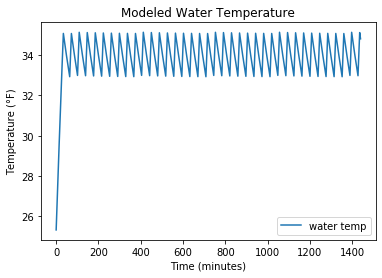

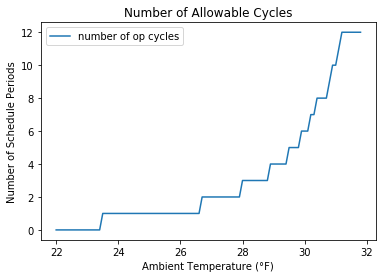

In [16]:
# Demonstrate Model in Simple System
t0 = 25
t_amb = 20

model = unit_model(t0,P,g)
water_temp = []

# Process twenty-four hours
minutes = 60*24
for _ in range(minutes):
    # Update the Model Instances
    model.update(t_amb)
    # Retrieve Water Temp
    water_temp.append(model.get_temp())

# Display Results
plt.plot(water_temp,label='water temp')
plt.xlabel("Time (minutes)")
plt.ylabel("Temperature (°F)")
plt.legend()
plt.title("Modeled Water Temperature")
plt.show()

# Demonstrate Baseline
baseline_temps, baseline_cycles = model.cycle_baseline(lut_fmt=False)
plt.plot(baseline_temps,baseline_cycles,label='number of op cycles')
plt.xlabel('Ambient Temperature (°F)')
plt.ylabel('Number of Schedule Periods')
plt.legend()
plt.title("Number of Allowable Cycles")
plt.show()

## Develop Scheduling/Dispatching System

Now that we have a real-time validation system, capable of more accurate modeling and built-in cycle baseline generation, we need to derive an effective system that can model the baseline management, and appropriately switch heaters on and off to manage load balancing.

In [45]:
class system_model():
    def __init__(self,ambient,shutoff=35):
        t0 = ambient
        k = k_full
        self.shutoff = shutoff
        self.turn_on = 33
        self.basemintemp=22
        self.basemaxtemp=31.9
        self.num_units = 12
        # Instantiate Model for Each Trough
        self.H1A = unit_model(t0,P,g,k,self.shutoff,self.turn_on,in_service=True)
        self.H1B = unit_model(t0,P,g,k,self.shutoff,self.turn_on,in_service=True)
        self.H2A = unit_model(t0,P,g,k,self.shutoff,self.turn_on,in_service=True)
        self.H2B = unit_model(t0,P,g,k,self.shutoff,self.turn_on,in_service=True)
        self.H3A = unit_model(t0,P,g,k,self.shutoff,self.turn_on,in_service=True)
        self.H3B = unit_model(t0,P,g,k,self.shutoff,self.turn_on,in_service=True)
        self.H4A = unit_model(t0,P,g,k,self.shutoff,self.turn_on,in_service=True)
        self.H4B = unit_model(t0,P,g,k,self.shutoff,self.turn_on,in_service=True)
        self.H5A = unit_model(t0,P,g,k,self.shutoff,self.turn_on,in_service=True)
        self.H5B = unit_model(t0,P,g,k,self.shutoff,self.turn_on,in_service=True)
        self.H6A = unit_model(t0,P,g,k,self.shutoff,self.turn_on,in_service=True)
        self.H6B = unit_model(t0,P,g,k,self.shutoff,self.turn_on,in_service=True)
        self.STOCK = unit_model(t0,P,g,k,self.shutoff,self.turn_on,in_service=True)
        self.models = [self.H1A,self.H1B,self.H2A,self.H2B,self.H3A,self.H3B,
                       self.H4A,self.H4B,self.H5A,self.H5B,self.H6A,self.H6B]
        # Remove Out-of-Service Heaters from List
        models = []
        for model in self.models:
            if model.get_service():
                models.append(model)
        self.models = models
        # Determine the System Baseline
        base_const = 0
        # Iteratively Query the Baseline Constant from Each Model
        for model in self.models:
            const = float(model.baseline_const())
            if const > base_const:
                # New Baseline Determined
                base_const = const
                base_model = model
        # Generate New Look-Up Function Based on Baseline LUT
        self.base_lut = model.cycle_baseline(mintemp=self.basemintemp,maxtemp=self.basemaxtemp,units=self.num_units)
    
    def lookup_cycles(self,value):
        if value > self.basemaxtemp:
            cyc = -3
        elif value < self.basemintemp:
            cyc = 0
        else:
            value = '%.1f' % value
            cyc = self.base_lut[value]
        return(cyc+3)
    
    def update(self,ambient):
        if ambient < self.turn_on:
            # Determine Number of Cycles Allowed
            n_cycles = self.lookup_cycles(ambient)
            # Prioritize Troughs According to Current Temperature
            priorities = {}
            for model in self.models:
                priorities[model.get_temp()] = model # Add Dictionary Item with Temp as Key
            # Load Prioritized List
            priorities = dict(OrderedDict(sorted(priorities.items())))
            c_temps = list(priorities.keys())
            models = list(priorities.values()) # Extract Ordered List
            # Determine Number to Be Enabled
            if min(c_temps) > self.turn_on:
                # All Water Temperatures are Above Minimum Threshold
                n_contr = int(len(models)/(n_cycles))
                # Split into Active and Not Active Groups
                active = models[:n_contr]
                inactive = models[n_contr:]
                # Update Active Heaters
                for heater in active:
                    heater.update(ambient,EN=True)
                # Update Inactive Heaters
                for heater in inactive:
                    heater.update(ambient,EN=False)
            else:
                for heater in models:
                    heater.update(ambient,EN=True)
            # Manage Stock Tank
            self.STOCK.update(ambient,EN=True) # Stock Tank is Unregulated by Dispatch
        else:
            for heater in self.models:
                heater.update(ambient,EN=False)
            self.STOCK.update(ambient,EN=False) # Stock Tank is Unregulated by Dispatch
    
    def get_state(self):
        # Iteratively Collect Heater States
        states = []
        for model in self.models:
            states.append(model.get_heater_state())
        states.append(self.STOCK.get_heater_state()) # Stock Tank is Unregulated by Dispatch
        return(states)
    
    def get_temp(self):
        # Iteratively Collect Water Temperatures
        temps = []
        for model in self.models:
            temps.append(model.get_temp())
        temps.append(self.STOCK.get_temp()) # Stock Tank is Unregulated by Dispatch
        return(temps)
    
    def get_consumption(self):
        # Iteratively Collect Heater Power if Heater is Active
        p_tot = 0
        for model in self.models:
            if model.get_heater_state():
                p_tot += model.get_power()
        # Return Load in kWatts
        return(p_tot)

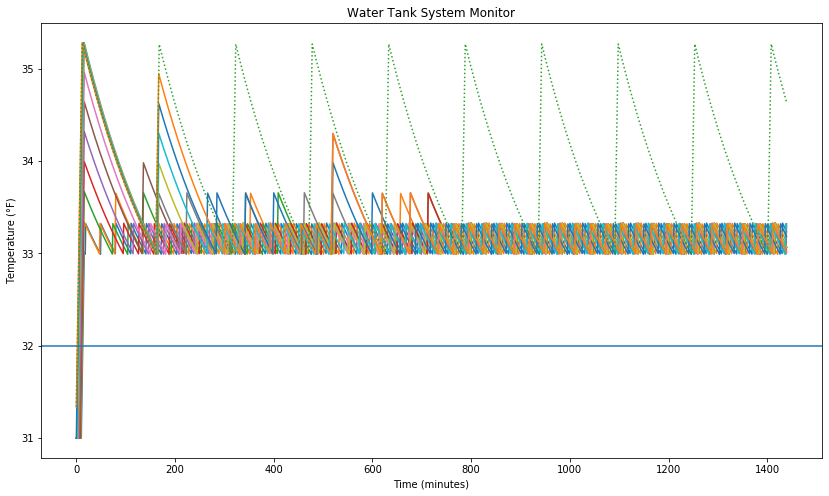

Number Of Available Cycles: 13
Minimum Managable Temperature: -10


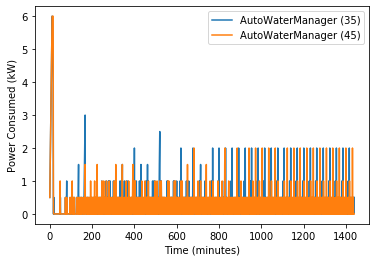

Total Energy Consumed (AutoWaterManager): 5.458333333333333 kWh
Total Energy Consumed (uncontrolled): 5.491666666666666 kWh


In [48]:
# Test System Model
ambient = 31

system = system_model(ambient)
system1 = system_model(ambient,45)
time = []
power = []
power1 = []
water_temp = [[],[],[],[],[],[],[],[],[],[],[],[],[]]

# Process twenty-four hours
minutes = 60*24
for i in range(minutes):
    # Update the Model Instances
    system.update(ambient)
    system1.update(ambient)
    # Retrieve Water Temp
    temp = system.get_temp()
    # Split into Lists
    for ind,item in enumerate(temp):
        water_temp[ind].append(item)
    time.append(i)
    power.append(system.get_consumption())
    power1.append(system1.get_consumption())

# Plot Temperatures Over Time
plt.figure(figsize=(14, 8))
for i,temp in enumerate(water_temp):
    if i < 12:
        plt.plot(time,temp,label='water temp '+str(i+1))
    else:
        plt.plot(time,temp,linestyle=':',label='stock water temp')
plt.axhline(32)
plt.xlabel('Time (minutes)')
plt.ylabel('Temperature (°F)')
plt.title("Water Tank System Monitor")
plt.show()

print("Number Of Available Cycles:",system.lookup_cycles(ambient))
print("Minimum Managable Temperature:",min_maintain(g,P,temp_maint=None,k=water_k_full))

# Plot Power Consumption Over Time
plt.plot(time,power,label='AutoWaterManager (35)')
plt.plot(time,power1,label='AutoWaterManager (45)')
plt.legend()
plt.xlabel('Time (minutes)')
plt.ylabel('Power Consumed (kW)')
plt.show()

energy = sum(power)/60
energy1 = sum(power1)/60
print("Total Energy Consumed (AutoWaterManager):",energy,"kWh")
print("Total Energy Consumed (uncontrolled):",energy1,"kWh")

## Evaluate Improvement
Compare to the original model using 45 degrees as the threshold.

In [49]:
# Demonstrate Model in Simple System
t0 = ambient
t_amb = ambient

model = troughmodel(t0,P,g,water_k_full,threshold=45)

# Process twenty-four hours
minutes = 60*24
for _ in range(minutes):
    # Update the Model Instances
    model.update(t_amb)

rate = sum(model.get_heater_state())/60
consump = (P/1000) * rate * 13
print("kWh Consumed (unregulated):",consump)
print("Percent Improvement (35):",(consump-energy)/consump*100,"%")
print("Percent Improvement (45):",(consump-energy1)/consump*100,"%")

kWh Consumed (unregulated): 18.525000000000002
Percent Improvement (35): 70.53531264057581 %
Percent Improvement (45): 70.35537561853351 %


## Discussion
These are very exciting numbers! According to an average temperature dataset provided by Google, January in Weippe sees an average of 28°F, according to this analysis, that means that we will see upwards of a 50% improvement across the system.

Further, according to Google resources, temperatures in February average around 31 degrees. This average leads to a 70% improvement in efficiency. Fantastic!